In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
%pip install --upgrade scanpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
from GraphST import GraphST

In [3]:
# Run device, by default, the package is implemented on 'cpu'. We recommend using GPU.
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace the path below with local R installation path
os.environ['R_HOME'] = 'C:/Users/AGNISH/.conda/envs/GraphST/Lib/R/'

In [4]:
# the number of clusters
n_clusters = 7

In [16]:
dataset = '151673'

In [17]:
#input_dir = 'C:/Users/AGNISH/Desktop/IITK/VSCode/GraphST/151673/'
#adata = sc.read_10x_h5(input_dir +'filtered_feature_bc_matrix.h5')
#adata.var_names_make_unique()

# read data
file_fold = 'C:/Users/AGNISH/GraphST/Data/' + str(dataset) #please replace 'file_fold' with the download path
adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [18]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [19]:
adata.obs

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACAATCTACTAGCA-1,1,3,43
AAACACCAATAACTGC-1,1,59,19
AAACAGAGCGACTCCT-1,1,14,94
AAACAGCTTTCAGAAG-1,1,43,9
...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42
TTGTTTCATTAGTCTA-1,1,60,30
TTGTTTCCATACAACT-1,1,45,27
TTGTTTGTATTACACG-1,1,73,41


In [20]:
adata.var

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38
...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,GRCh38
AC233755.1,ENSG00000275063,Gene Expression,GRCh38
AC240274.1,ENSG00000271254,Gene Expression,GRCh38
AC213203.1,ENSG00000277475,Gene Expression,GRCh38


In [21]:
# define model
model = GraphST.GraphST(adata, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|██████████| 600/600 [13:58<00:00,  1.40s/it]


Optimization finished for ST data!


In [22]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'emb'

In [11]:
%pip install -i https://test.pypi.org/simple/ "scikit-misc==0.2.0rc1"

Looking in indexes: https://test.pypi.org/simple/
  Using cached https://test-files.pythonhosted.org/packages/a5/f7/c8348e6fa8173c5298f125dc889b9c122f135f6d35c24643d3120d30882c/scikit_misc-0.2.0rc1-cp38-cp38-win_amd64.whl (9.9 MB)
  Attempting uninstall: scikit-misc
    Found existing installation: scikit-misc 0.1.4
    Uninstalling scikit-misc-0.1.4:
      Successfully uninstalled scikit-misc-0.1.4
Note: you may need to restart the kernel to use updated packages.


In [15]:
%pip install --upgrade numpy

                                              0.0/14.9 MB ? eta -:--:--
                                             0.0/14.9 MB 660.6 kB/s eta 0:00:23
                                              0.1/14.9 MB 1.4 MB/s eta 0:00:11
                                              0.3/14.9 MB 2.5 MB/s eta 0:00:06
     -                                        0.5/14.9 MB 3.0 MB/s eta 0:00:05
     -                                        0.7/14.9 MB 3.3 MB/s eta 0:00:05
     --                                       0.9/14.9 MB 3.5 MB/s eta 0:00:04
     ---                                      1.2/14.9 MB 3.8 MB/s eta 0:00:04
     ---                                      1.4/14.9 MB 3.9 MB/s eta 0:00:04
     ----                                     1.6/14.9 MB 4.0 MB/s eta 0:00:04
     -----                                    1.9/14.9 MB 4.1 MB/s eta 0:00:04
     -----                                    2.1/14.9 MB 4.2 MB/s eta 0:00:04
     ------                                   2.3/14.9 MB 

In [28]:
%pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [23]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'mclust' # mclust, leiden, and louvain

# clustering
from GraphST.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=False)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [37]:
%Rinstall.packages("mclust")


UsageError: Line magic function `%Rinstall.packages("mclust")` not found.


In [24]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values

In [25]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Dataset: 151673
ARI: 0.6331903767517718


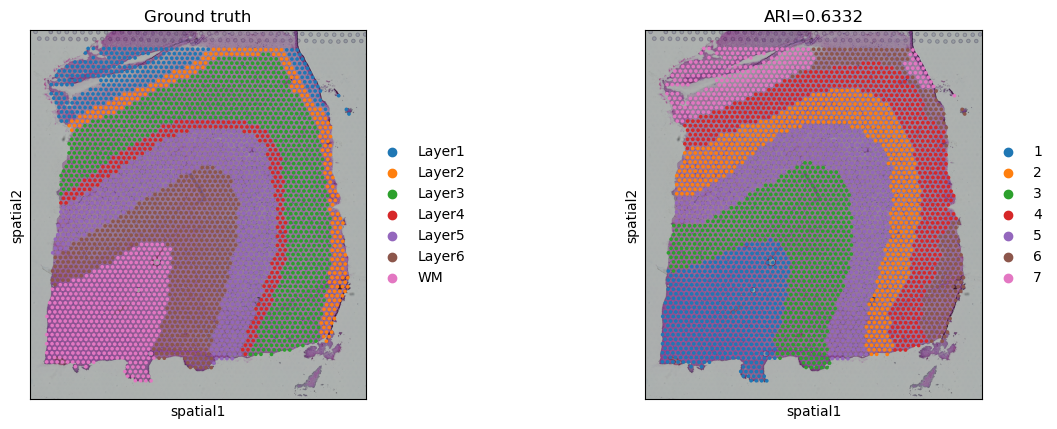

In [26]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\AGNISH\.conda\envs\GraphST\lib\site-packages\umap\distances.py:1086: NumbaDepreca

<Axes: title={'center': 'Predicted labels'}, xlabel='UMAP1', ylabel='UMAP2'>

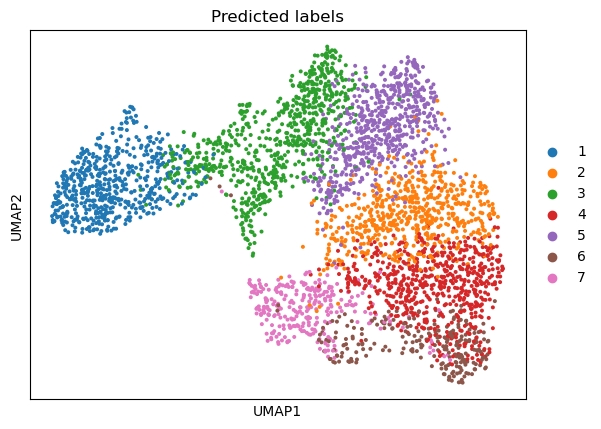

In [27]:
# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=False)